In [1]:
import os

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.signal.windows import triang

import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

from momentfm import MOMENTPipeline

from finetune import finetune_reflectance



True
1
NVIDIA GeForce RTX 4090


/workspace/svi_momentts_imputing/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/svi_momentts_imputing/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
df = pd.read_csv("processed_reflectance.csv")
df_all = df.sort_values("timestamp").reset_index(drop=True)

spec_cols = [c for c in df_all.columns if c != "timestamp"]

In [3]:
def plot_reflectance_heatmap(df, spectral_prefix="", 
                             wl_start=400, cmap="RdYlGn",
                             vmin=-0.075, vmax=0.275,
                             title="Reflectance Variation Over Time",
                             figsize=(10,7)):
    """
    Plot time × wavelength reflectance heatmap.
    df must contain a 'timestamp' column and spectral_bin_* columns.
    """

    if "timestamp" not in df.columns:
        raise ValueError("DataFrame must contain a 'timestamp' column.")

    # Spectral columns
    spec_cols = [c for c in df.columns if c != "timestamp"]
    if len(spec_cols) == 0:
        raise ValueError(f"No columns starting with '{spectral_prefix}' found.")

    # Convert values → matrix
    data = df[spec_cols].to_numpy()

    # Wavelength axis
    wl_end = wl_start + len(spec_cols) - 1
    wavelengths = np.arange(wl_start, wl_end + 1)

    # Date labels
    dates = pd.to_datetime(df["timestamp"]).dt.strftime("%Y-%m-%d")

    # Plot
    plt.figure(figsize=figsize)

    plt.imshow(
        data,
        aspect='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=[wavelengths[0], wavelengths[-1], len(df), 0],
        origin='upper'      # time runs from top to bottom
    )

    plt.colorbar(label="Reflectance")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Date")
    plt.title(title, fontsize=14)

    # Y-ticks → readable dates
    yticks = np.linspace(0, len(df)-1, 10).astype(int)
    plt.yticks(yticks, dates.iloc[yticks], rotation=0)

    plt.tight_layout()
    plt.show()

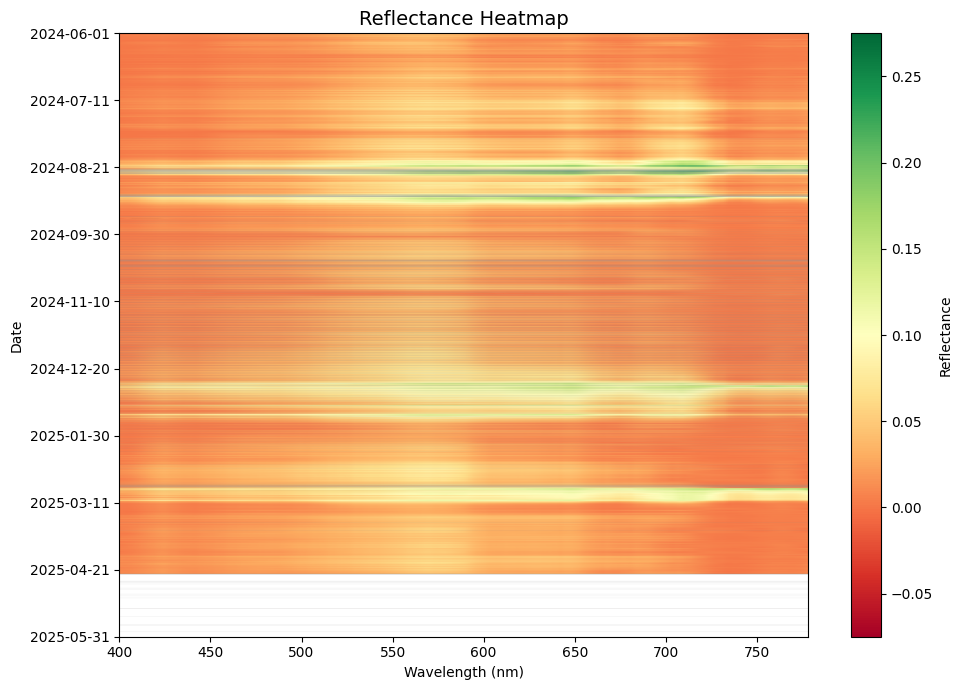

In [4]:
plot_reflectance_heatmap(
    df_all,
    title="Reflectance Heatmap",
)

In [5]:
def interpolate_spectrum_fill_all(y, smooth=True, window=15, poly=3):
    """
    y: 1D array of shape (n_wavelengths,), may contain np.nan.
    Fills *all* gaps (NaNs) in a partially valid spectrum.

    - uses linear interpolation along wavelength
    - extrapolates edges with nearest valid value
    - optional Savitzky–Golay smoothing on the filled curve
    """
    y = y.astype(float)
    x = np.arange(len(y))

    mask = ~np.isnan(y)
    n_valid = mask.sum()

    # No or almost no information → return as is (still NaN)
    if n_valid < 2:
        return y

    x_valid = x[mask]
    y_valid = y[mask]

    # Linear interpolation + edge extrapolation
    # np.interp fills interior by interpolation and outside with boundary values
    y_filled = np.interp(x, x_valid, y_valid)

    if smooth:
        # apply gentle smoothing on the fully filled curve
        if len(y_filled) >= window:
            y_smooth = savgol_filter(y_filled, window_length=window, polyorder=poly)
            return y_smooth
        else:
            # not enough points for this window length
            return y_filled

    return y_filled

# df: your original DataFrame
# spec_cols: list of spectral_bin_* columns, e.g.:
# spec_cols = [c for c in df.columns if c.startswith("spectral_bin_")]

df_processed = df.copy()

is_fully_nan = df_processed[spec_cols].isna().all(axis=1)
is_partially_nan = df_processed[spec_cols].isna().any(axis=1) & ~is_fully_nan

rows_to_work_on = df_processed[is_partially_nan].index

for idx in rows_to_work_on:
    row = df_processed.loc[idx, spec_cols].to_numpy(dtype=float)

    # fill all gaps in that row across all bins
    row_filled = interpolate_spectrum_fill_all(
        row,
        smooth=True,   # set to False if you don’t want smoothing
        window=15,
        poly=3
    )

    df_processed.loc[idx, spec_cols] = row_filled

print("Per-row interpolation complete (all gaps filled in partial rows).")

# Keep fully-NaN rows as they are
df_ready_for_moment = df_processed.sort_values("timestamp").reset_index(drop=True)

print("\nData is now ready.")
print(f"Total rows: {len(df_ready_for_moment)}")
print(
    "Rows with full gaps (still NaN):",
    df_ready_for_moment[spec_cols].isna().all(axis=1).sum()
)

df = df_ready_for_moment.copy()
df

Per-row interpolation complete (all gaps filled in partial rows).

Data is now ready.
Total rows: 16425
Rows with full gaps (still NaN): 2059


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
1,2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2,2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
3,2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
4,2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16420,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16421,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16422,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16423,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


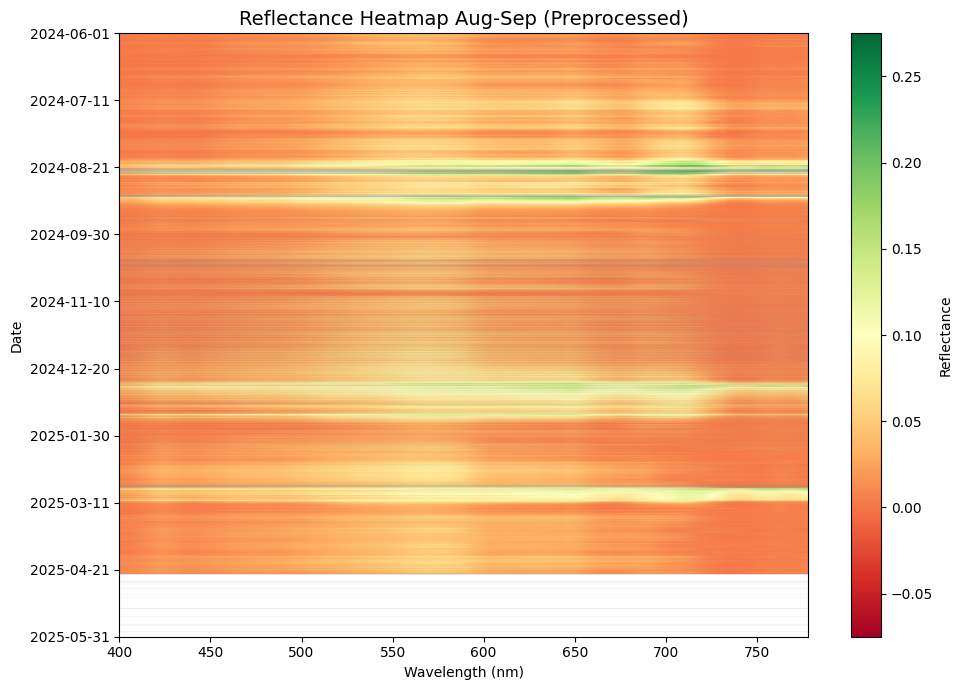

In [6]:
plot_reflectance_heatmap(
    df,
    title="Reflectance Heatmap Aug-Sep (Preprocessed)",
)

In [7]:
df = df_ready_for_moment.copy()
spec_cols = [c for c in df.columns if c != "timestamp"]

print("rows:", len(df), "features:", len(spec_cols))
print("fully-NaN rows:", df[spec_cols].isna().all(axis=1).sum())
print("any-NaN rows:", df[spec_cols].isna().any(axis=1).sum())

valid = ~df[spec_cols].isna().any(axis=1)
runs = (valid != valid.shift()).cumsum()
max_run = valid.groupby(runs).sum().max()

print("Longest contiguous fully-valid run:", int(max_run))

df = df_ready_for_moment.copy()
spec_cols = [c for c in df.columns if c != "timestamp"]

# keep ONLY rows that have no NaNs across spectrum
df_train = df.loc[~df[spec_cols].isna().any(axis=1)].reset_index(drop=True)

print("train rows:", len(df_train))

df_train

rows: 16425 features: 379
fully-NaN rows: 2059
any-NaN rows: 2059
Longest contiguous fully-valid run: 2881
train rows: 14366


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
1,2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2,2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
3,2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
4,2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14361,2025-05-14 16:45:00+07:00,0.004920,0.004837,0.004746,0.004653,0.004565,0.004488,0.004426,0.004388,0.004378,...,0.006922,0.006949,0.006993,0.007057,0.007145,0.007258,0.007401,0.007576,0.007785,0.008033
14362,2025-05-19 14:30:00+07:00,0.011706,0.011558,0.011419,0.011294,0.011186,0.011098,0.011034,0.010996,0.010989,...,0.007035,0.007026,0.007032,0.007058,0.007107,0.007182,0.007288,0.007427,0.007605,0.007824
14363,2025-05-24 13:45:00+07:00,0.017234,0.016427,0.015758,0.015224,0.014821,0.014548,0.014400,0.014374,0.014468,...,0.004604,0.004933,0.005425,0.006096,0.006964,0.008043,0.009350,0.010901,0.012711,0.014799
14364,2025-05-24 17:45:00+07:00,0.015856,0.014513,0.013369,0.012417,0.011650,0.011063,0.010647,0.010396,0.010303,...,0.004851,0.004594,0.004326,0.004058,0.003800,0.003564,0.003361,0.003201,0.003095,0.003055


In [8]:
# # Your df_ready_for_moment is already created from the previous step.
# SEQ_LEN = 512       # Window size for the model. 512 is a good default for MOMENT.
# NUM_EPOCHS = 5      # Number of times to loop through the data. Start with 5-10.
# OUTPUT_DIR = "finetuned_model"

# # Run the fine-tuning process
# print("\nStarting model fine-tuning...")
# finetuned_model = finetune_reflectance(
#     seq_len=SEQ_LEN, 
#     num_epochs=NUM_EPOCHS, 
#     input_dataframe=df_train  # <-- Here is where you use your dataframe
# )
# print("Fine-tuning complete.")

# # Step 3: Save Your New, Specialized Model
# os.makedirs(OUTPUT_DIR, exist_ok=True)
# model_save_path = os.path.join(OUTPUT_DIR, f"reflectance_imputer_epoch_{NUM_EPOCHS}.pt")
# torch.save(finetuned_model.state_dict(), model_save_path)

# print(f"\nYour fine-tuned model has been saved to: {model_save_path}")

In [9]:
# --- Step 1: Load Your Fine-Tuned Model ---


# Ensure this path points to your saved model file
MODEL_PATH = "finetuned_model/reflectance_imputer_epoch_5.pt" 

# Load the base architecture
inference_model = MOMENTPipeline.from_pretrained("AutonLab/MOMENT-1-large")

# Load your custom, fine-tuned weights into the architecture
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

# Set up the model for inference
# device: force GPU 1 if present
device = torch.device("cuda:1" if torch.cuda.is_available() and torch.cuda.device_count() > 1 else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

inference_model = MOMENTPipeline.from_pretrained("AutonLab/MOMENT-1-large")
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location="cpu"))
inference_model = inference_model.to(device).float().eval()


# --- Step 2: Prepare the Data ---

# Use the dataframe that has partials filled but full gaps remaining as NaN
# For example, loading it from a file if you saved it:
# df_ready_for_moment = pd.read_csv('df_ready_for_moment.csv', parse_dates=['timestamp'])
df = df_ready_for_moment.copy() 
df = df.sort_values("timestamp").set_index("timestamp")

spec_cols = [c for c in df.columns if c != "timestamp"]
T = len(df)

# Use the same window size you fine-tuned with
win = 512
stride = win // 2 # Use overlap for smooth stitching

X_spec = df[spec_cols].values.astype(np.float32)
mask_spec = np.isnan(X_spec)
X_fill = np.nan_to_num(X_spec, nan=0.0)

# --- Step 3: Create Batches and Run Inference ---

# Pad for even windowing
if T % stride != 0:
    pad_len = stride - (T % stride)
    X_fill_padded = np.pad(X_fill, ((0, pad_len), (0, 0)), 'constant', constant_values=0)
else:
    X_fill_padded = X_fill
T_padded = X_fill_padded.shape[0]

starts = np.arange(0, T_padded - win + 1, stride)
Xs = []
for s in starts:
    seg = X_fill_padded[s:s+win, :].T
    Xs.append(seg[:, None, :])

X_batch = np.concatenate(Xs, axis=0)

with torch.no_grad():
    x_enc = torch.tensor(X_batch, dtype=torch.float32, device=device)
    input_mask = torch.ones(x_enc.shape[0], x_enc.shape[-1], device=device, dtype=torch.long)
    out = inference_model(x_enc=x_enc, input_mask=input_mask)

recon = out.reconstruction.detach().cpu().numpy().squeeze(1)

# --- Step 4: Smooth Stitching with Weighted Averaging ---

stitching_window = triang(win).reshape(-1, 1)
imputed_padded = np.zeros_like(X_fill_padded, dtype=float)
counts = np.zeros_like(X_fill_padded, dtype=float)
ptr = 0

for s in starts:
    block = recon[ptr : ptr + len(spec_cols), :].T
    imputed_padded[s : s + win, :] += block * stitching_window
    counts[s : s + win, :] += stitching_window
    ptr += len(spec_cols)

imputed_padded /= (counts + 1e-8)
imputed = imputed_padded[:T, :]

# --- Step 5: Finalize and Visualize ---

# Fill only the large gaps identified by the original mask
filled = X_spec.copy()
filled[mask_spec] = imputed[mask_spec]

df_final_imputed = df.copy()
df_final_imputed[spec_cols] = np.clip(filled, 0, None)

print("\nImputation with fine-tuned model complete!")

Using device: cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.92 GiB. GPU 0 has a total capacity of 47.38 GiB of which 3.73 GiB is free. Process 2571052 has 43.64 GiB memory in use. Of the allocated memory 43.13 GiB is allocated by PyTorch, and 70.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
df_final_imputed[spec_cols].isna().sum().sum()
df_final_imputed

In [ ]:
df_final_imputed = df_final_imputed.reset_index()
plot_reflectance_heatmap(
    df_final_imputed,
    title="Reflectance Heatmap Aug-Sep (MOMENT Imputed)",
)

In [ ]:
df_final_imputed.to_csv("imputed_MOMENT_with_finetune.csv", index=False)